# Using PySpark

## Configure Spark Session

For this notebook to run you specifically need python==8, spark <= 3.2, and Hadoop <= 3

In [ ]:
# This is needed for my local installation so UDF functions don't error
import os
os.environ['PYSPARK_DRIVER_PYTHON'] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ['PYSPARK_PYTHON'] = "C:\\Users\\Ethan\\miniconda3\\envs\\sparknlp\\python.exe"

In [2]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.config("spark.driver.host", "localhost").appName(
    "Steam Reviews Analysis")\
    .config("spark.ui.port","4050")\
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")\
    .config("spark.kryoserializer.buffer.max", "2000m")\
    .config("spark.jsl.settings.pretrained.cache_folder", "sample_data/pretrained")\
    .config("spark.jsl.settings.storage.cluster_tmp_dir", "sample_data/storage")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.5.0")\
    .getOrCreate()  # Get an existing SparkSession or create a new one

# Verify Spark version
print("Spark version: ", spark.version)

Spark version:  3.2.3


# Exploring the Dataset

## Define the Schema

In [3]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, ShortType, FloatType, TimestampType

schema_optimized = StructType([
    StructField("recommendationid", LongType(), True),  # IDs are large, so we use LongType
    StructField("appid", IntegerType(), True),  # Small app id, IntegerType is sufficient
    StructField("game", StringType(), True),  # Game name, StringType
    StructField("author_steamid", LongType(), True),  # Steam IDs are large, LongType
    StructField("author_num_games_owned", ShortType(), True),
    StructField("author_num_reviews", ShortType(), True),  # Small number, ShortType
    StructField("author_playtime_forever", IntegerType(), True),  # Playtime is typically integer hours/minutes
    StructField("author_playtime_last_two_weeks", IntegerType(), True),  # Playtime in the last 2 weeks
    StructField("author_playtime_at_review", IntegerType(), True),  # Playtime at the time of review
    StructField("author_last_played", LongType(), True),  # Unix timestamp for the last played time
    StructField("language", StringType(), True),  # Language of the review, StringType
    StructField("review", StringType(), True),  # Review text, StringType
    StructField("timestamp_created", LongType(), True),  # Unix timestamp, LongType
    StructField("timestamp_updated", LongType(), True),  # Unix timestamp, LongType
    StructField("voted_up", ShortType(), True),  # Boolean field for recommendation status
    StructField("votes_up", ShortType(), True),  # Small integer for votes, ShortType
    StructField("votes_funny", ShortType(), True),  # Small integer for funny votes, ShortType
    StructField("weighted_vote_score", FloatType(), True),  # Floating point score
    StructField("comment_count", ShortType(), True),  # Small integer, ShortType
    StructField("steam_purchase", ShortType(), True),  # Boolean for Steam purchase
    StructField("received_for_free", ShortType(), True),  # Boolean for free product
    StructField("written_during_early_access", ShortType(), True),  # Boolean for early access
    StructField("hidden_in_steam_china", ShortType(), True),  # Boolean field for Steam China
    StructField("steam_china_location", StringType(), True)  # Optional field, StringType
])

## Load the Dataset

In [4]:
# Load data from csv to a dataframe
df = spark.read.csv('all_reviews.csv', header=True, schema=schema_optimized)
df.show(5, truncate=False)

+----------------+-----+--------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+---------------------+--------------------+
|recommendationid|appid|game          |author_steamid   |author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|language|review            |timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|hidden_in_steam_china|steam_china_location|
+----------------+-----+--------------+-----------------+----------------------+------------------+-----------------------+-------------

Drop unnecessary columns

In [ ]:
# Remove columns about china and other columns we won't use at all
df = df.drop("hidden_in_steam_china", "steam_china_location", "comment_count", "weighted_vote_score")

Convert binary columns to boolean so they take up less space

In [6]:
# Convert columns that are only 0 and 1 to boolean columns to save space
import pyspark.sql.functions as F
boolean_columns = [
    "voted_up",
    "steam_purchase",
    "received_for_free",
    "written_during_early_access"
]

# Convert each ShortType column back to BooleanType (0 -> False, 1 -> True)
for col_name in boolean_columns:
    df = df.withColumn(col_name, F.col(col_name).cast("boolean"))

### Partitioning
Allocating the "appropriate" amount of cores according to people

In [7]:
# Get the total number of cores assigned to the Spark job
num_cores = spark.sparkContext.defaultParallelism
print(f"Total number of cores available: {num_cores}")

Total number of cores available: 8


In [ ]:
# we will use the recommened number of partitions of 2-4 (this case 4) per every core meaning 8 partitions
print("Partitions before repartition:", df.rdd.getNumPartitions())
df = df.repartition(num_cores*4)
print("Partitions after repartition:", df.rdd.getNumPartitions())

Partitions before repartition: 317
Partitions after repartition: 32


# Exploring the Data

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Basic Operations (Filtering, GroupBy, Aggregates, etc.)

GroupBy and Plot

In [9]:
# We'll use a groupby on languages to see how many reviews are in each language
num_reviews_per_language = df.groupBy('language').count().collect()

C:\Users\Ethan\AppData\Local\Temp\ipykernel_28200\2272431565.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='language', y='count', data=languages_df, palette='viridis')


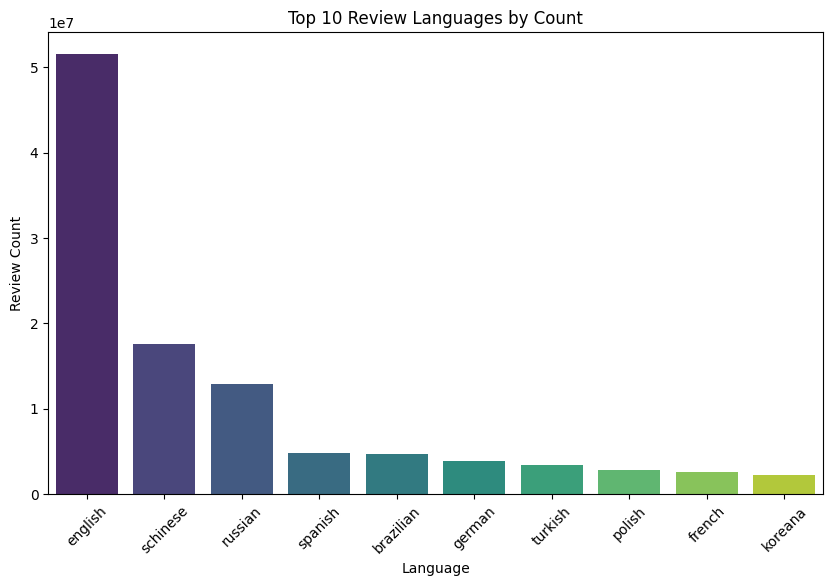

In [ ]:
top_10_review_languages = sorted(num_reviews_per_language, key=lambda x: x[1], reverse=True)[:10]

top_10_review_languages = {
    'language': [x[0] for x in top_10_review_languages],
    'count': [x[1] for x in top_10_review_languages]
    }
# Create a DataFrame from the list
languages_df = pd.DataFrame(top_10_review_languages)

# Create a barplot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='language', y='count', data=languages_df, palette='viridis')

# Set title and labels
plt.title('Top 10 Review Languages by Count')
plt.xlabel('Language')
plt.ylabel('Review Count')

# Show the plot
plt.xticks(rotation=45)
plt.show()

Quickly remove any-non english reviews to decrease the size of our datset (filtering)

In [9]:
# We'll use a filter operation to remove all non-english reviews
print("Total Number of Reviews:", df.count())
df = df.filter(df['language'] == 'english')
print("Total English Reviews:", df.count())

Total Number of Reviews: 113885601
Total English Reviews: 51544179


In [10]:
# We'll next find the number of distinct games to inform our next repartition
game_review_counts = df.groupBy("game").agg(
    F.count("*").alias("review_count")
)

game_review_counts_with_avg = game_review_counts.agg(
    F.avg("review_count").alias("avg_reviews_per_game"),
    F.countDistinct("game").alias("distinct_games_count")
)
game_review_counts_with_avg.show()

+--------------------+--------------------+
|avg_reviews_per_game|distinct_games_count|
+--------------------+--------------------+
|     534.17531841688|               96492|
+--------------------+--------------------+



Remove games with less than 200 reviews

In [11]:
# We'll also filter out games with less than 200 reviews
filtered_games = game_review_counts.select("game").filter(F.col("review_count") >= 200)

# Join the filtered games back to the original DataFrame to retain only those games
df = df.join(filtered_games, on="game", how="inner")

We would repartition into 300 partitions by game as the next set of groupby operations are within each game (repartitioning)

In [10]:
# Repartition on each game since most of our operations will be by game
# We will set our partitions to 300
# This makes our number of Games per partition: 96,492 / 300 ~ 321 GPP
# This games our number of Reviews per partition 51,544,179 / 300 ~ 171,813 RPP

df = df.repartition(300, "game")

# Check the number of partitions
print(f"Number of partitions: {df.rdd.getNumPartitions()}")

Number of partitions: 300


Game Overview Stats using SQL Functions

In [ ]:

game_review_stats = df.groupby("game").agg(F.avg('author_playtime_forever').alias('avg_playtime'), 
                       F.avg('author_playtime_last_two_weeks').alias('avg_playtime_2wks'), 
                       F.sum('votes_up').alias('total_comment_votes_up'), 
                       F.sum('votes_funny').alias('total_comment_votes_funny')
                       ).filter(F.col('avg_playtime') > 0).orderBy(F.col('avg_playtime').desc())
game_review_stats.show(limit=10)

Using a map partition to count how many games are in each partition

In [ ]:
# We'll use mapPartitions to count unique games in each partition
def count_unique_games_in_partition(iterator):
    games = set()  # Use a set to track unique games
    for row in iterator:
        games.add(row["game"])
    yield len(games)  # Return the number of unique games in this partition


# Apply the function to each partition and collect the results
unique_games_per_partition = df.rdd.mapPartitions(count_unique_games_in_partition).collect()

# Calculate the average number of unique games per partition
average_unique_games_per_partition = sum(unique_games_per_partition) / len(unique_games_per_partition)

print(f"Average number of unique games per partition: {average_unique_games_per_partition:.2f}")

Average number of unique games per partition: 318.17


# Cleaning and Preparing the data

## Handling Missing data

## Prepare the data for sentinment analysis

In [12]:
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
import gc

In [13]:
# Get only game name and reviews to reduce dataset size
minimal_df = df.select("game", "review")

df.unpersist(blocking=True)
del df

# Perform Unsupervised Sentiment Analysis
Using User Defined Function (UDF)

In [14]:
from pyspark.sql.types import DoubleType

def sentiment_score(text):
    try:
        return TextBlob(text).sentiment.polarity
    except Exception:
        return None  # Handle exceptions if any text causes issues


sentiment_udf = F.udf(sentiment_score, DoubleType())
minimal_df = minimal_df.withColumn("sentiment", sentiment_udf("review"))

In [19]:
minimal_df.show(20)

+----------+--------------------+--------------------+
|      game|              review|           sentiment|
+----------+--------------------+--------------------+
|HYPERFIGHT|time for you to c...|                 0.0|
|HYPERFIGHT|HYPERFIGHT is an ...|0.002380952380952405|
|HYPERFIGHT|terrible game,ter...|-0.38333333333333336|
|HYPERFIGHT|Game is fucking d...|                -0.5|
|HYPERFIGHT|Chaotic fun with ...| 0.09999999999999999|
|HYPERFIGHT|Low-budget Street...|                -0.4|
|HYPERFIGHT|i cant imagine a ...|                 0.5|
|HYPERFIGHT|game good, me lik...|-0.03125000000000002|
|HYPERFIGHT|                   .|                 0.0|
|HYPERFIGHT|Its a good game a...| 0.14999999999999997|
|HYPERFIGHT|the only good fig...| 0.09999999999999998|
|HYPERFIGHT|absolutely incred...| 0.27428571428571424|
|HYPERFIGHT|No players online...|-0.36904761904761907|
|HYPERFIGHT|                  Gg|                 0.0|
|HYPERFIGHT|The fighting game...|                -0.4|
|HYPERFIGH

# Subset just The Witcher 3: Wild Hunt

In [20]:
# Let's get The Wither 3: Wild Hunt to focus on
game_df = minimal_df.filter(F.col("game") == "The Witcher 3: Wild Hunt").cache()

# Explicitly unpersist minimal_df to free up memory if it was cached
minimal_df.unpersist(blocking=True)

# Delete minimal_df and call garbage collection to fully release memory
del minimal_df
gc.collect()  # Run garbage collection

641

In [32]:
game_df = game_df.repartition(32)

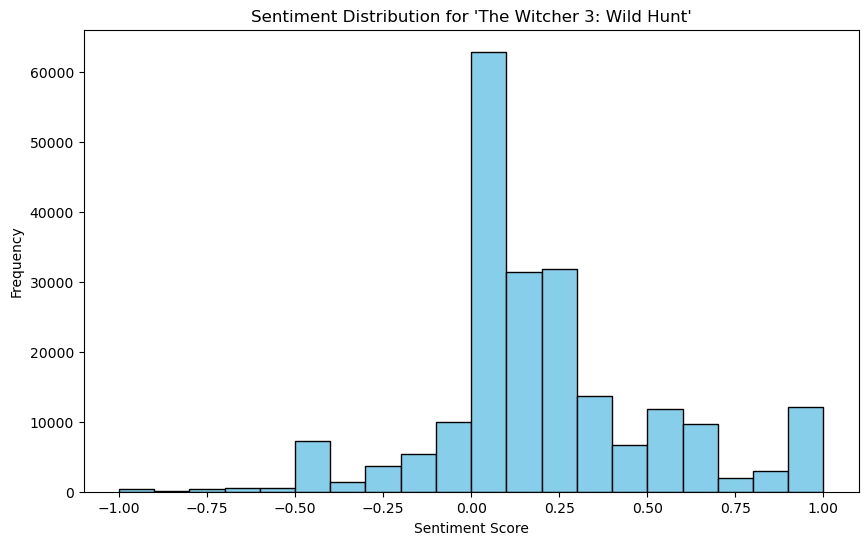

In [21]:
# Convert the sentiment column to Pandas for plotting
sentiment_data = game_df.select("sentiment").dropna().toPandas()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(sentiment_data["sentiment"], bins=20, color='skyblue', edgecolor='black')
plt.title("Sentiment Distribution for 'The Witcher 3: Wild Hunt'")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

# Perform Entity Recognition and Generate Word Clouds

In [22]:
# Load the pretrained Spark NLP pipeline for Named Entity Recognition (NER)
pipeline = PretrainedPipeline('explain_document_dl', lang='en')

explain_document_dl download started this may take some time.
Approx size to download 168 MB
[OK!]


In [23]:
# helper function to combine entities
def make_string(entities):
    return ' '.join(entities)

make_string_udf = F.udf(make_string, StringType())

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
custom_stopwords = set(["I've", "I'm", "i'm", "i've", "ive", "game", "games", "witcher", "geralt", "gwent", "i'll"])
stop_words = stop_words.union(custom_stopwords)

# Define a function to remove stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

# Register the stopword removal function as a UDF
remove_stopwords_udf = F.udf(remove_stopwords, StringType())

In [ ]:
# Function that applies entity extraction and removes stopwords
def extract_entities_for_game(df):
    # Rename the column "review" to "text" for compatibility with the pipeline
    df = df.withColumnRenamed("review", "text")

    # Apply the NLP pipeline for entity extraction
    entities_df = pipeline.transform(df.select("text")) \
                          .select(F.col("text"),
                                  F.col("entities.result").alias("entities"))

    # Convert entities list to a single string for each row and remove stopwords
    entities_df = entities_df.withColumn("entities_str", make_string_udf("entities")) \
                             .filter(F.col("entities_str") != "")  # Keep rows with extracted entities only
    entities_df = entities_df.withColumn("entities_str", remove_stopwords_udf("entities_str"))  # Apply stopword removal
    return entities_df

In [ ]:
# Function to generate a word cloud from the entity frequencies
def generate_wordcloud(entities_df, game_name="The Witcher 3: Wild Hunt"):
    # Flatten and count entity frequencies
    corpus = entities_df.select("entities_str").rdd.flatMap(lambda x: x[0].split()) \
                        .map(lambda x: (x, 1)) \
                        .reduceByKey(lambda x, y: x + y) \
                        .toDF(["entity", "count"])

    # Convert to dictionary for word cloud generation
    corpus_dict = {row["entity"]: row["count"] for row in corpus.collect()}

    # Generate and display the word cloud
    wordcloud = WordCloud().generate_from_frequencies(corpus_dict)
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{game_name} Word Cloud")
    plt.show()

Word Cloud plots for Positive and Negative Reviews

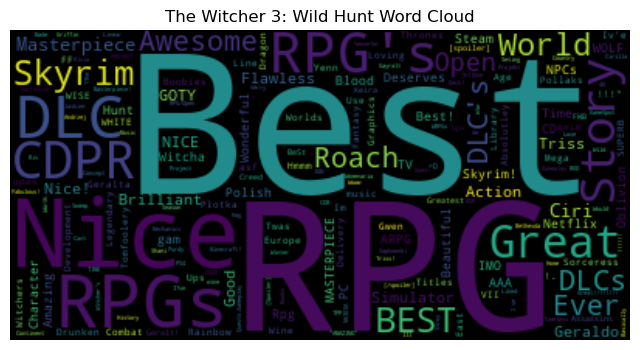

In [52]:
# Apply entity extraction with stopword removal and generate word cloud on game_df
entities_df = extract_entities_for_game(game_df.filter(F.col("sentiment") > 0.5).limit(2000))
generate_wordcloud(entities_df)

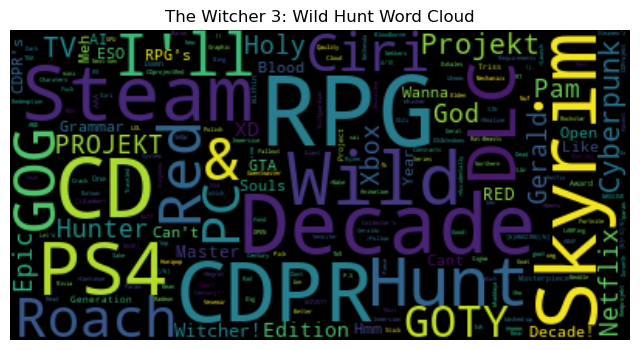

In [53]:
# Apply entity extraction with stopword removal and generate word cloud on game_df
entities_df = extract_entities_for_game(game_df.filter(F.col("sentiment") < -0.1).limit(1000))
generate_wordcloud(entities_df)